First 5 rows of the dataset:
         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  radius_worst  texture_wor

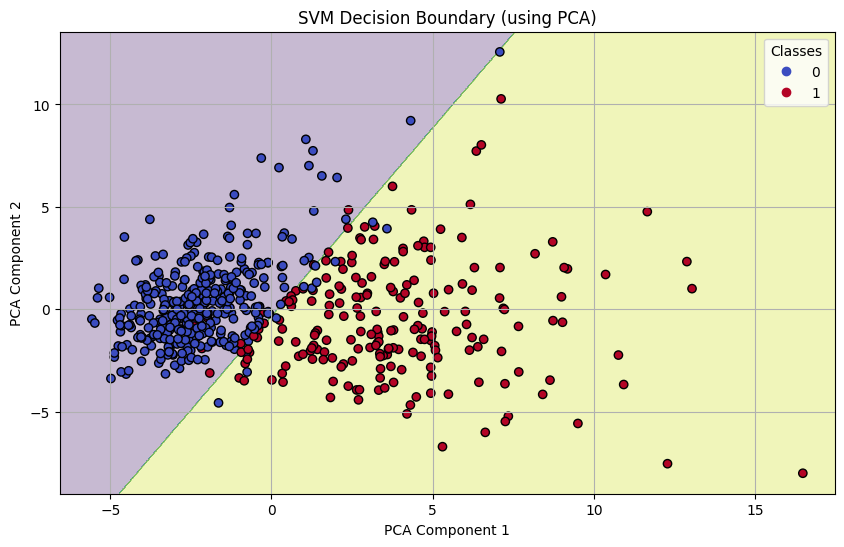

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score

# Load dataset
df = pd.read_csv("breast-cancer.csv")
print("First 5 rows of the dataset:")
print(df.head())

# Check for null values
print("\nMissing values:\n", df.isnull().sum())

# Convert target labels: M (malignant) -> 1, B (benign) -> 0
y = df['diagnosis'].map({'M': 1, 'B': 0})
X = df.drop('diagnosis', axis=1)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42)

# ------------------- Linear SVM -------------------
svm_linear = SVC(kernel='linear', C=1.0)
svm_linear.fit(X_train, y_train)
y_pred_linear = svm_linear.predict(X_test)

print("\nLinear SVM Classification Report:")
print(classification_report(y_test, y_pred_linear))
print("Accuracy (Linear Kernel):", accuracy_score(y_test, y_pred_linear))

# ------------------- RBF SVM -------------------
svm_rbf = SVC(kernel='rbf', C=1.0, gamma='scale')
svm_rbf.fit(X_train, y_train)
y_pred_rbf = svm_rbf.predict(X_test)

print("\nRBF SVM Classification Report:")
print(classification_report(y_test, y_pred_rbf))
print("Accuracy (RBF Kernel):", accuracy_score(y_test, y_pred_rbf))

# ------------------- Hyperparameter Tuning -------------------
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.1, 1],
    'kernel': ['rbf']
}
grid = GridSearchCV(SVC(), param_grid, cv=5, verbose=0)
grid.fit(X_train, y_train)

print("\nBest Parameters from GridSearchCV:")
print(grid.best_params_)

# Predict with best model
y_pred_best = grid.predict(X_test)
print("\nTuned RBF SVM Classification Report:")
print(classification_report(y_test, y_pred_best))
print("Accuracy (Tuned RBF Kernel):", accuracy_score(y_test, y_pred_best))

# ------------------- Cross-validation -------------------
cv_scores = cross_val_score(grid.best_estimator_, X_scaled, y, cv=5)
print("\nCross-validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))

# ------------------- Visualization using PCA -------------------
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Train SVM again on 2D PCA data
svm_vis = SVC(kernel='linear', C=1.0)
svm_vis.fit(X_pca, y)

# Meshgrid for decision boundary
h = .02
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = svm_vis.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.astype(float)  # Convert class predictions to float
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.3)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, edgecolors='k', cmap=plt.cm.coolwarm)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title("SVM Decision Boundary (using PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()
